Seeing that Hyperface with VGG16 as main model is so big, we decide to try to train in a 'smaller' architecture (SqueezeNet https://arxiv.org/abs/1602.07360v3).

Reducing the size of AlexNet:
- SVD: 5x compression, 56% top-1 accuracy
- Pruning: 9x compression, 57.2% top-1 accuracy
- Deep Compression: 35x compression, ~57% top-1 accuracy
- SqueezeNet: 50x compression, ~57% top-1 accuracy

In [11]:
from keras import backend as K
from keras.models import Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import os
import time
import numpy as np
import h5py
import squeeze
import hf


Dropping classifier block in Squeeze model. The net already has pretrained weights.

In [12]:
model = squeeze.SqueezeNet()
model = Model(inputs=model.input, outputs=model.get_layer('drop9').output)
# model.summary()

In [13]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D, merge
from keras.layers.merge import concatenate

#
# # fire2/concat (56x56x128) porque se asemeja a paper (27x27x96, aunque en imagen luce 51x51x96)
# conv1a_input = model.get_layer('fire2/concat').output
# # con kernel=9x9/9 llegamos a 6x6x128 en paper es 6x6x256
# conv1a = Convolution2D(128, (9,9), strides=(9,9), activation='relu', padding='valid', name='conv1a')(conv1a_input)
#
# pool3 (27x27x128) se asemeja mejor 
conv1a_input = model.get_layer('pool3').output
# con kernel=4x4/4 llegamos a 6x6x128 en paper es 6x6x256
conv1a = Convolution2D(128, (4,4), strides=(4,4), activation='relu', padding='valid', name='conv1a')(conv1a_input)
print(conv1a_input.shape, '->', conv1a.shape)

# pool5 (13x13x256) paper (13x13x384)
conv3a_input = model.get_layer('pool5').output
conv3a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
print(conv3a_input.shape, '->', conv3a.shape)

# no tiene nombre así que le nombramos conv5a
# drop9 (13x13x512) paper (6x6x256, aunque en imagen luce 13x13x256)
conv5a_input = model.get_layer('drop9').output
conv5a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv5a')(conv5a_input)
print(conv5a_input.shape, '->', conv5a.shape)

# combinación: 6x6x384 (paper: 6x6x768)
concat = concatenate([conv1a, conv3a, conv5a], axis=-1, name='concat')
print(concat.shape)

# reducción de dimensión: 4x4x128 (paper: 6x6x192)
# todo: obtendremos la misma accuracy que entrenando con kernel=(1,1) pero cambios en todas las conv precedentes para llegar a 4x4?
# ya que es una fusión de características no parece buena idea mezclar todas haciendo una conv 3x3
conv_all = Convolution2D(128, (3, 3), strides=(1,1), activation='relu', padding='valid', name='conv_all')(concat)
print(conv_all.shape)

# completamente conectadas
fc_full = Flatten(input_shape=conv_all.shape, name='fc_full')(conv_all)
print(fc_full.shape)

(?, 27, 27, 128) -> (?, 6, 6, 128)
(?, 13, 13, 256) -> (?, 6, 6, 128)
(?, 13, 13, 512) -> (?, 6, 6, 128)
(?, 6, 6, 384)
(?, 4, 4, 128)
(?, ?)


<!--<img src="squeezenet-architecture.png"/>-->
<img src="HyperFace-architecture.small.png"/>
It is important to use Keras functional API.

In [14]:
from keras.regularizers import l2

# face/non-face
fc_detecton = Dense(256, name='fc_detecton', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
face_nonface = Dense(2, name='face_nonface', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_detecton)
# print(fc_detecton.shape, face_nonface.shape)

fc_landmarks = Dense(256, name='fc_landmarks', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
landmarks = Dense(42, name='landmarks', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_landmarks)
# print(fc_landmarks.shape, landmarks.shape)

fc_visibility = Dense(256, name='fc_visibility', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
visibility = Dense(21, name='visibility', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_visibility)
# print(fc_visibility.shape, visibility.shape)

fc_pose = Dense(256, name='fc_pose', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
roll_pitch_yaw = Dense(3, name='roll_pitch_yaw', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_pose)
# print(fc_pose.shape, roll_pitch_yaw.shape)

fc_gender = Dense(256, name='fc_gender', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
male_female = Dense(2, name='male_female', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_gender)
# print(fc_gender.shape, male_female.shape)

hyperface = Model(inputs=model.input, outputs=[face_nonface, landmarks, visibility, roll_pitch_yaw, male_female])
# hyperface.summary()

In [15]:
import tensorflow as tf
import keras.backend as kb
import keras.losses as losses
from keras.optimizers import Adam, RMSprop

def custom_loss_visibility(y_true, y_pred):
    # en paper: loss = 1/N * sum((vpredi-vi)^2)
    # para entrenar:
    return (1/21) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/21) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_pose(y_true, y_pred):
    # en paper: loss = 1/3 * sum((ppredi-pi)^2)
    # para entrenamiento:
    return (1/3) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/3) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_landmarks(coord_true, coord_pred):    
    # en paper: loss = 1/(2N) * Sum(vi*((xpredi-ai)^2 + (ypredi-bi)^2))
    x_true_coord = coord_true[:,0:21]
    y_true_coord = coord_true[:,21:42]
    # viz_true = coord_true[:,42:63]  # produce errores en otros entornos (versión de keras?)
    x_pred_coord = coord_pred[:,0:21]
    y_pred_coord = coord_pred[:,21:42]
    # para entrenamiento:
    # return (1/(2*21)) * kb.sum(viz_true * (kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    return (1/(2*21)) * kb.sum((kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    # para debug:
    # return (1/(2*21)) * np.sum(viz_true * ((x_pred_coord-x_true_coord)**2 + (y_pred_coord - y_true_coord)**2), axis=-1)

def custom_mse_lm(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*kb.sum(kb.square(tf.multiply((kb.sign(y_true)+1)*0.5, y_true-y_pred)),axis=-1)/kb.sum((kb.sign(y_true)+1)*0.5,axis=-1)

optimizer = Adam(lr=0.0001)
hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'landmarks': custom_loss_landmarks,
                      'visibility': custom_loss_visibility,
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'landmarks': 1,
                      'visibility': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1})
print("hyperface model compiled")

hyperface model compiled


In [16]:
import hf

print("Building train/validation data generator...")

# para corregir el problema de una imagen jpg no válida:
# convert -resize 50% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg
# convert -resize 200% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg
json_dir = os.path.dirname(os.path.realpath('__file__')) # genérico

train_data = hf.ImageDataGeneratorV2(samplewise_center=True,                                     
                                     samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,
                                                 'negatives5k-train.json', 'positives5k-train.json', 
                                                 # 'positives.json', 'negatives.json', 
                                                 pos_max_load_labels=12116, neg_max_load_labels=12116*3, #Número de negativos 454512
                                                 output_type='hyperface', target_size=(227, 227),
                                                 pos_batch_size=64, neg_batch_size=64)

val_data = hf.ImageDataGeneratorV2(samplewise_center=True,            
                                    samplewise_std_normalization=True)
val_data_flow = val_data.flow_from_directory(json_dir, 
                                              'negatives5k-test.json', 'positives5k-test.json', 
                                              pos_max_load_labels=505, neg_max_load_labels=505*3, #Número de negativos 18938
                                              output_type='hyperface', target_size=(227, 227),
                                              pos_batch_size=64, neg_batch_size=64)

# # checkpoint
# filepath="weights-{epoch:02d}-{loss:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, mode='min', period=30)
# callbacks_list = [checkpoint]

print("Start training...")
# history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=300, callbacks=callbacks_list)
history = hyperface.fit_generator(generator=train_data_flow, 
                                   validation_data=val_data_flow,
                                   validation_steps=100,
                                  steps_per_epoch=100, epochs=25) 
#                                   steps_per_epoch=100, epochs=30)

Building train/validation data generator...
Found 12116 positive samples and 12116 negative samples.
Found 505 positive samples and 505 negative samples.
Start training...
Epoch 1/25
  5/100 [>.............................] - ETA: 15:40 - loss: 4.4623 - face_nonface_loss: 0.0148 - landmarks_loss: 2.5882 - visibility_loss: 0.2440 - roll_pitch_yaw_loss: 1.6152 - male_female_loss: 0.0000e+00

C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


 12/100 [==>...........................] - ETA: 13:16 - loss: 2.3934 - face_nonface_loss: 0.0090 - landmarks_loss: 1.2979 - visibility_loss: 0.1552 - roll_pitch_yaw_loss: 0.9314 - male_female_loss: 0.0000e+00

C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 36/100 [=========>....................] - ETA: 9:17 - loss: 0.9425 - face_nonface_loss: 0.0081 - landmarks_loss: 0.4788 - visibility_loss: 0.0923 - roll_pitch_yaw_loss: 0.3632 - male_female_loss: 0.0000e+00

C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 77/100 [======================>.......] - ETA: 3:19 - loss: 0.4702 - face_nonface_loss: 0.0038 - landmarks_loss: 0.2350 - visibility_loss: 0.0469 - roll_pitch_yaw_loss: 0.1845 - male_female_loss: 0.0000e+00

C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


100/100 [==============================] - 1259s 13s/step - loss: 0.3656 - face_nonface_loss: 0.0030 - landmarks_loss: 0.1818 - visibility_loss: 0.0364 - roll_pitch_yaw_loss: 0.1444 - male_female_loss: 0.0000e+00 - val_loss: 0.0053 - val_face_nonface_loss: 2.8573e-05 - val_landmarks_loss: 3.3758e-04 - val_visibility_loss: 0.0010 - val_roll_pitch_yaw_loss: 0.0039 - val_male_female_loss: 0.0000e+00
Epoch 2/25
100/100 [==============================] - 1205s 12s/step - loss: 0.0044 - face_nonface_loss: 8.7822e-06 - landmarks_loss: 1.8487e-04 - visibility_loss: 3.4269e-04 - roll_pitch_yaw_loss: 0.0039 - male_female_loss: 0.0000e+00 - val_loss: 0.0015 - val_face_nonface_loss: 7.3849e-06 - val_landmarks_loss: 7.5267e-06 - val_visibility_loss: 1.7435e-04 - val_roll_pitch_yaw_loss: 0.0013 - val_male_female_loss: 0.0000e+00
Epoch 3/25
100/100 [==============================] - 1214s 12s/step - loss: 0.0018 - face_nonface_loss: 5.4893e-06 - landmarks_loss: 7.2457e-06 - visibility_loss: 1.3404e-0

100/100 [==============================] - 1086s 11s/step - loss: 7.8375e-05 - face_nonface_loss: 1.8939e-07 - landmarks_loss: 3.5160e-08 - visibility_loss: 2.2729e-06 - roll_pitch_yaw_loss: 7.5877e-05 - male_female_loss: 0.0000e+00 - val_loss: 6.5074e-05 - val_face_nonface_loss: 1.5162e-07 - val_landmarks_loss: 5.1947e-08 - val_visibility_loss: 1.9519e-06 - val_roll_pitch_yaw_loss: 6.2918e-05 - val_male_female_loss: 0.0000e+00
Epoch 19/25
100/100 [==============================] - 1111s 11s/step - loss: 7.1333e-05 - face_nonface_loss: 1.7759e-07 - landmarks_loss: 2.2936e-08 - visibility_loss: 2.0085e-06 - roll_pitch_yaw_loss: 6.9124e-05 - male_female_loss: 0.0000e+00 - val_loss: 6.2196e-05 - val_face_nonface_loss: 1.4944e-07 - val_landmarks_loss: 4.3908e-08 - val_visibility_loss: 1.8507e-06 - val_roll_pitch_yaw_loss: 6.0152e-05 - val_male_female_loss: 0.0000e+00
Epoch 20/25
100/100 [==============================] - 1091s 11s/step - loss: 6.0149e-05 - face_nonface_loss: 1.6660e-07 - l

Predecir

In [17]:
data_flow = train_data.flow_from_directory(json_dir,
                                            'negatives5k-train.json', 'positives5k-train.json', 
                                            # 'positives.json', 'negatives.json', 
                                            pos_max_load_labels=12116, neg_max_load_labels=12116*3, #Número de negativos 454512
                                            output_type='predict', target_size=(227, 227),
                                            pos_batch_size=64, neg_batch_size=64)
batch_x, batch_image, batch_bbox, batch_y_fnf, batch_y_landmarks, batch_y_visfac, batch_y_pose, batch_y_gender = data_flow.next()

# DO NOT LOAD LIKE THIS, USE A REGION FIRST!
# path = batch_image[0]
# print("loading", path)
# img = image.load_img(path, target_size=(227, 227))
# x = image.img_to_array(img)
# x = train_data.standardize(x)
# x = np.expand_dims(x, axis=0)

subject = 0
x = batch_x[subject]
x = np.expand_dims(x, axis=0)

preds = hyperface.predict(x)

print('Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)')

print('face_nonface ground truth:')
print(batch_y_fnf[subject])
print('face_nonface predicted:')
print(preds[0])
print()

print('landmarks ground truth:')
print(batch_y_landmarks[subject])
print('landmarks predicted:')
print(preds[1])
print()

print('visibility ground truth:')
print(batch_y_visfac[subject])
print('visibility predicted:')
print(preds[2])
print()

print('pose ground truth:')
print(batch_y_pose[subject])
print('pose predicted:')
print(preds[3])
print()

print('gender ground truth:')
print(batch_y_gender[subject])
print('gender predicted:')
print(preds[4])
print()

Found 12116 positive samples and 12116 negative samples.
Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)
face_nonface ground truth:
[0 1]
face_nonface predicted:
[[  4.53685232e-08   1.00000000e+00]]

landmarks ground truth:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
landmarks predicted:
[[ -1.16454665e-07  -3.13893977e-08   7.63012849e-06   3.28865866e-07
   -1.11974828e-06  -6.68034409e-06  -4.32044629e-07   7.62155469e-06
    1.80779568e-06   2.26687462e-07   1.14269489e-04  -3.95842144e-05
   -5.30707766e-05  -1.46989887e-05   9.11433631e-07   1.14984584e-06
   -1.40033819e-06  -9.86578016e-07  -5.76703371e-07   4.01092757e-06
   -7.51229963e-05  -4.60335104e-05  -3.79526028e-07  -2.97709448e-05
   -4.13479465e-05   8.86376620e-06   5.06723723e-07   3.45885127e-07
   -9.39209031e-08  -6.47640150e-07   2.68219537e-07   5.91

C:\Users\Asus\Anaconda2\envs\keras\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


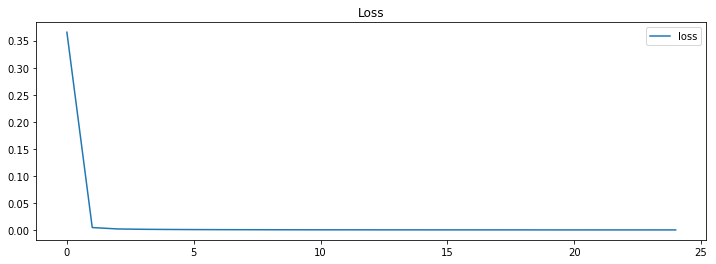

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.DataFrame(history.history)
# df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
# df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy')
df.plot(y=['loss'], figsize=(12,4), title='Loss')
# df

In [ ]:
import h5py
hyperface.save_weights("hyperface.weights.h5")

model_yaml = hyperface.to_yaml()
with open("hyperface.model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# throws json non serializable exception
# model_json = hyperface.to_json()
# with open("hyperface.model.json", "w") as json_file:
#     json_file.write(model_json)

print("model written")

### Testing with a model without heads

In [11]:
hyperface_faceposegender = Model(inputs=model.input, outputs=[face_nonface, roll_pitch_yaw, male_female])
optimizer = Adam(lr=0.0001)
hyperface_faceposegender.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1})
print("hyperface_faceposegender model compiled")

json_dir = os.path.dirname(os.path.realpath('__file__')) # genérico
train_data = hf.ImageDataGeneratorV2(samplewise_center=True,                                     
                                     samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,
                                                 'positives.json3k', 'negatives.json3k', 
                                                 # 'positives.json', 'negatives.json', 
                                                 pos_max_load_labels=2, neg_max_load_labels=2,
                                                 output_type='faceposegender', target_size=(227, 227),
                                                 pos_batch_size=64, neg_batch_size=64)
print("training...")
history = hyperface_faceposegender.fit_generator(generator=train_data_flow, 
                                  steps_per_epoch=100, epochs=5)

hyperface_faceposegender model compiled
Found 2 positive samples and 2 negative samples.
training...
Epoch 1/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1951e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 2/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 3/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 4/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 5/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     


Predecir

In [14]:
data_flow = train_data.flow_from_directory(json_dir,
                                           'positives.json3k', 'negatives.json3k', 
                                           # 'positives.json', 'negatives.json', 
                                           pos_max_load_labels=1, neg_max_load_labels=1,
                                           output_type='predict', target_size=(227, 227),
                                           pos_batch_size=64, neg_batch_size=64)
batch_x, batch_image, batch_bbox, batch_y_fnf, batch_y_landmarks, batch_y_visfac, batch_y_pose, batch_y_gender = data_flow.next()

# DO NOT LOAD LIKE THIS, USE A REGION FIRST!
# path = batch_image[0]
# print("loading", path)
# img = image.load_img(path, target_size=(227, 227))
# x = image.img_to_array(img)
# x = train_data.standardize(x)
# x = np.expand_dims(x, axis=0)

x = batch_x[0]
x = np.expand_dims(x, axis=0)

preds = hyperface_faceposegender.predict(x)

print('Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)')

print('face_nonface ground truth:')
print(batch_y_fnf[0])
print('face_nonface predicted:')
print(preds[0])
print()

print('pose ground truth:')
print(batch_y_pose[0])
print('pose predicted:')
print(preds[1])
print()

print('gender ground truth:')
print(batch_y_gender[0])
print('gender predicted:')
print(preds[2])
print()

Found 1 positive samples and 1 negative samples.
Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)
face_nonface ground truth:
[1 0]
face_nonface predicted:
[[  9.86067116e-01   6.11221317e-12]]

pose ground truth:
[-0.12002859 -0.22056605 -0.40335208]
pose predicted:
[[  2.77214002e-10   3.17766813e-10   7.23532623e-11]]

gender ground truth:
[0 1]
gender predicted:
[[  6.42394287e-13   1.00000000e+00]]



Testing SqueezeNet

In [3]:
model = squeeze.SqueezeNet()

path = '/home/lmiguel/Projects/datasets/coco/images/test2017/000000000665.jpg'
img = image.load_img(path, target_size=(227, 227))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n02123045', 'tabby', 0.8085466), ('n02123159', 'tiger_cat', 0.14428307), ('n02124075', 'Egyptian_cat', 0.043808475), ('n02971356', 'carton', 0.0009396731), ('n02127052', 'lynx', 0.00060345326)]]
